In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.utils import concat_csv_with_indices

In [3]:
path = "./pseudocausal_broad_experiment_results.csv"

In [4]:
word_freq_df = pd.read_csv("data/WorldLex_Eng_US.Freq.2.txt", sep="\t", index_col="Word")
word_freq_df = word_freq_df.loc[~word_freq_df.index.duplicated()]
# compute weighted average frequency across domains
word_freq_df["BlogFreq_rel"] = word_freq_df.BlogFreq / word_freq_df.BlogFreq.sum()
word_freq_df["TwitterFreq_rel"] = word_freq_df.TwitterFreq / word_freq_df.TwitterFreq.sum()
word_freq_df["NewsFreq_rel"] = word_freq_df.NewsFreq / word_freq_df.NewsFreq.sum()
word_freq_df["Freq"] = word_freq_df[["BlogFreq_rel", "TwitterFreq_rel", "NewsFreq_rel"]].mean(axis=1) \
    * word_freq_df[["BlogFreq", "TwitterFreq", "NewsFreq"]].sum().mean()
word_freq_df["LogFreq"] = np.log10(word_freq_df.Freq)

In [5]:
df = pd.read_csv(path)

In [6]:
# merge in frequency information
df = pd.merge(df, word_freq_df.LogFreq.rename("from_freq"),
              left_on="from", right_index=True)
df = pd.merge(df, word_freq_df.LogFreq.rename("to_freq"),
                left_on="to", right_index=True)

In [7]:
evaluations = [re.findall("(.+)_target_rank", col)[0] for col in df.columns if col.endswith("_target_rank")]
evaluations

['matches_next_phoneme',
 'matches_next_phoneme_weak',
 'matches_cohort',
 'matches_cohort_and_next_phoneme',
 'matches_cohort_and_next_phoneme_weak']

In [8]:
cohort_length = df.to_base_phones.iloc[0].count(" ") + 1
assert df.to_base_phones.str.count(" ").unique().tolist() == [cohort_length - 1]
assert df.from_base_phones.str.count(" ").unique().tolist() == [cohort_length - 1]

In [9]:
# metadata
# control trials have mismatched source--target; this establishes a baseline success rate
df["control"] = df.inflection_to.str.split("-").str[-1] != df.inflection_from.str.split("-").str[-1]
# small cohort vs large cohort experiment
df["is_small_experiment"] = df.experiment.str.contains("to-small-")
df["inflection_from_clean"] = df.inflection_from.str.split("-").str[-1]
df["inflection_to_clean"] = df.inflection_to.str.split("-").str[-1]

for evaluation in evaluations:
    df[f"{evaluation}_correct"] = df[f"{evaluation}_target_rank"] == 0

# oops, these are redundantly recorded for all evaluations. just grab one
predicted_columns = ["predicted_phones", "predicted_phoneme_idx",
                     "predicted_label", "predicted_instance_idx"]
for col in predicted_columns:
    df[col] = df[f"{evaluations[0]}_{col}"]

# extract predicted phone
def get_predicted_phone(row):
    predicted_phones = row.predicted_phones.split(" ")
    predicted_phone_idx = cohort_length
    if len(predicted_phones) - 1 < predicted_phone_idx:
        return None
    return predicted_phones[predicted_phone_idx]
df["predicted_phone"] = df.apply(get_predicted_phone, axis=1)

## Prepare cohort statistics

In [10]:
cohort_types = pd.concat([
    df.groupby("from_base_phones").apply(lambda xs: xs.drop_duplicates("from")["from"]),
    df.groupby("to_base_phones").apply(lambda xs: xs.drop_duplicates("to")["to"])
]).droplevel(-1).rename("word")
cohort_types.index.names = ["base_phones"]
cohort_types

/tmp/ipykernel_2730144/448064641.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("from_base_phones").apply(lambda xs: xs.drop_duplicates("from")["from"]),
/tmp/ipykernel_2730144/448064641.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("to_base_phones").apply(lambda xs: xs.drop_duplicates("to")["to"])


base_phones
AH N     unattainable
AH N      unannounced
AH N     unattractive
AH N         unafraid
AH N    unaccountable
            ...      
W AW           wouter
W AW            wound
W AW           wowzer
Z AY             zion
Z AY            zeiss
Name: word, Length: 959, dtype: object

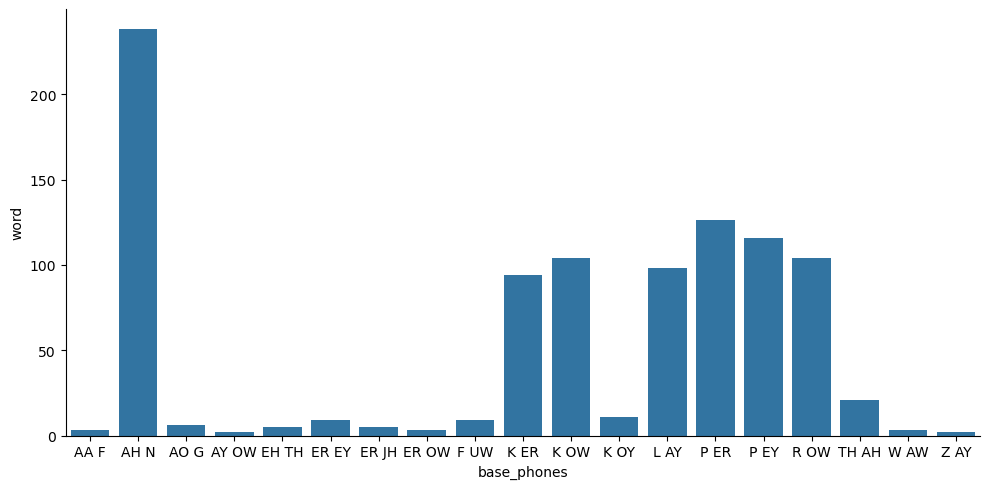

In [11]:
cohort_type_mass = cohort_types.groupby("base_phones").size()
sns.catplot(data=cohort_type_mass.reset_index(), x="base_phones", y="word", kind="bar", aspect=2)

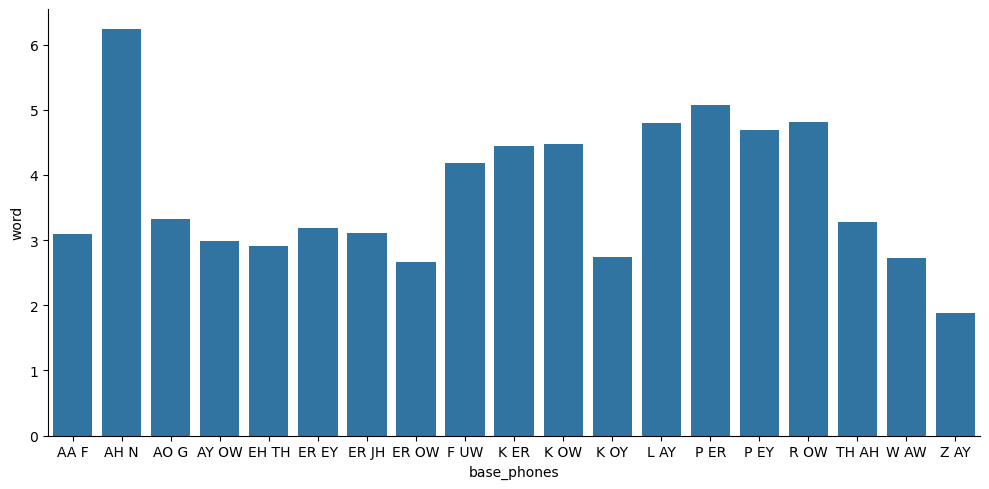

In [12]:
cohort_token_mass = np.log10(cohort_types.groupby("base_phones").apply(lambda xs: word_freq_df.loc[xs].Freq.sum()))
sns.catplot(data=cohort_token_mass.reset_index(), x="base_phones", y="word", kind="bar", aspect=2)

In [13]:
df = pd.merge(df, cohort_type_mass.rename("from_cohort_type_mass"),
              left_on="from_base_phones", right_index=True)
df = pd.merge(df, cohort_type_mass.rename("to_cohort_type_mass"),
              left_on="to_base_phones", right_index=True)
df = pd.merge(df, cohort_token_mass.rename("from_cohort_token_mass"),
              left_on="from_base_phones", right_index=True)
df = pd.merge(df, cohort_token_mass.rename("to_cohort_token_mass"),
              left_on="to_base_phones", right_index=True)

## Summarize

In [14]:
df.head()

,experiment,Unnamed: 1,matches_next_phoneme_target_rank,matches_next_phoneme_target_distance,matches_next_phoneme_target_label_idx,matches_next_phoneme_target_instance_idx,matches_next_phoneme_target_phoneme_idx,matches_next_phoneme_target_label,matches_next_phoneme_target_phones,matches_next_phoneme_predicted_distance,...,matches_cohort_and_next_phoneme_weak_correct,predicted_phones,predicted_phoneme_idx,predicted_label,predicted_instance_idx,predicted_phone,from_cohort_type_mass,to_cohort_type_mass,from_cohort_token_mass,to_cohort_token_mass
0,AH_to_AH,0,433,0.163196,21254,1,2,coalition,K OW AH L IH SH AH N,0.101592,...,False,K UH K ER IY,0,cookery,0,K,98,104,4.796168,4.483215
2,AH_to_AH,2,288,0.058192,3379,1,2,lion,L AY AH N,0.031351,...,False,L AE P IY EH R,1,lapierre,1,P,94,98,4.440363,4.796168
3,AH_to_AH,3,174,0.095089,6330,9,2,honestly,AA N AH S L IY,0.072087,...,False,AH N F L IH N CH IH NG,1,unflinching,4,F,94,238,4.440363,6.235994
4,AH_to_AH,4,25,0.102933,26726,0,2,coalitions,K OW AH L IH SH AH N Z,0.067235,...,False,K OW AH L IH SH AH N Z,1,coalitions,0,AH,98,104,4.796168,4.483215
5,AH_to_AH,5,14,0.069347,15455,2,2,unavoidably,AH N AH V OY D AH B L IY,0.053851,...,False,AH N D ER G AO N,0,undergone,6,D,94,238,4.440363,6.235994


In [15]:
all_phones = set(x.replace("small-", "") for x in df.inflection_from.values) | \
    set(x.replace("small-", "") for x in df.inflection_to.values)
all_phones

{'AH', 'D', 'ER', 'IH', 'L', 'M', 'N', 'S', 'T', 'Z'}

In [16]:
main_results = df[~df.is_small_experiment]
small_results = df[df.is_small_experiment]

In [17]:
main_results

,experiment,Unnamed: 1,matches_next_phoneme_target_rank,matches_next_phoneme_target_distance,matches_next_phoneme_target_label_idx,matches_next_phoneme_target_instance_idx,matches_next_phoneme_target_phoneme_idx,matches_next_phoneme_target_label,matches_next_phoneme_target_phones,matches_next_phoneme_predicted_distance,...,matches_cohort_and_next_phoneme_weak_correct,predicted_phones,predicted_phoneme_idx,predicted_label,predicted_instance_idx,predicted_phone,from_cohort_type_mass,to_cohort_type_mass,from_cohort_token_mass,to_cohort_token_mass
0,AH_to_AH,0,433,0.163196,21254,1,2,coalition,K OW AH L IH SH AH N,0.101592,...,False,K UH K ER IY,0,cookery,0,K,98,104,4.796168,4.483215
2,AH_to_AH,2,288,0.058192,3379,1,2,lion,L AY AH N,0.031351,...,False,L AE P IY EH R,1,lapierre,1,P,94,98,4.440363,4.796168
3,AH_to_AH,3,174,0.095089,6330,9,2,honestly,AA N AH S L IY,0.072087,...,False,AH N F L IH N CH IH NG,1,unflinching,4,F,94,238,4.440363,6.235994
4,AH_to_AH,4,25,0.102933,26726,0,2,coalitions,K OW AH L IH SH AH N Z,0.067235,...,False,K OW AH L IH SH AH N Z,1,coalitions,0,AH,98,104,4.796168,4.483215
5,AH_to_AH,5,14,0.069347,15455,2,2,unavoidably,AH N AH V OY D AH B L IY,0.053851,...,False,AH N D ER G AO N,0,undergone,6,D,94,238,4.440363,6.235994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91356,S_to_S,994,1,0.067480,21975,0,2,purser's,P ER S ER Z,0.066951,...,True,P ER S AH N Z,5,persons,98,S,126,126,5.067911,5.067911
91357,S_to_S,995,2,0.074369,13258,8,2,license,L AY S AH N S,0.069016,...,False,L AE K,0,lack,30,K,238,98,6.235994,4.796168
91358,S_to_S,996,0,0.075202,31914,0,2,unselfishness,AH N S EH L F IH SH N AH S,0.075202,...,True,AH N S EH L F IH SH N AH S,2,unselfishness,0,S,238,238,6.235994,6.235994
91359,S_to_S,997,0,0.140945,18588,2,2,unsuspected,AH N S AH S P EH K T IH D,0.140945,...,True,AH N S AH S P EH K T IH D,2,unsuspected,2,S,238,238,6.235994,6.235994


## Summary plots

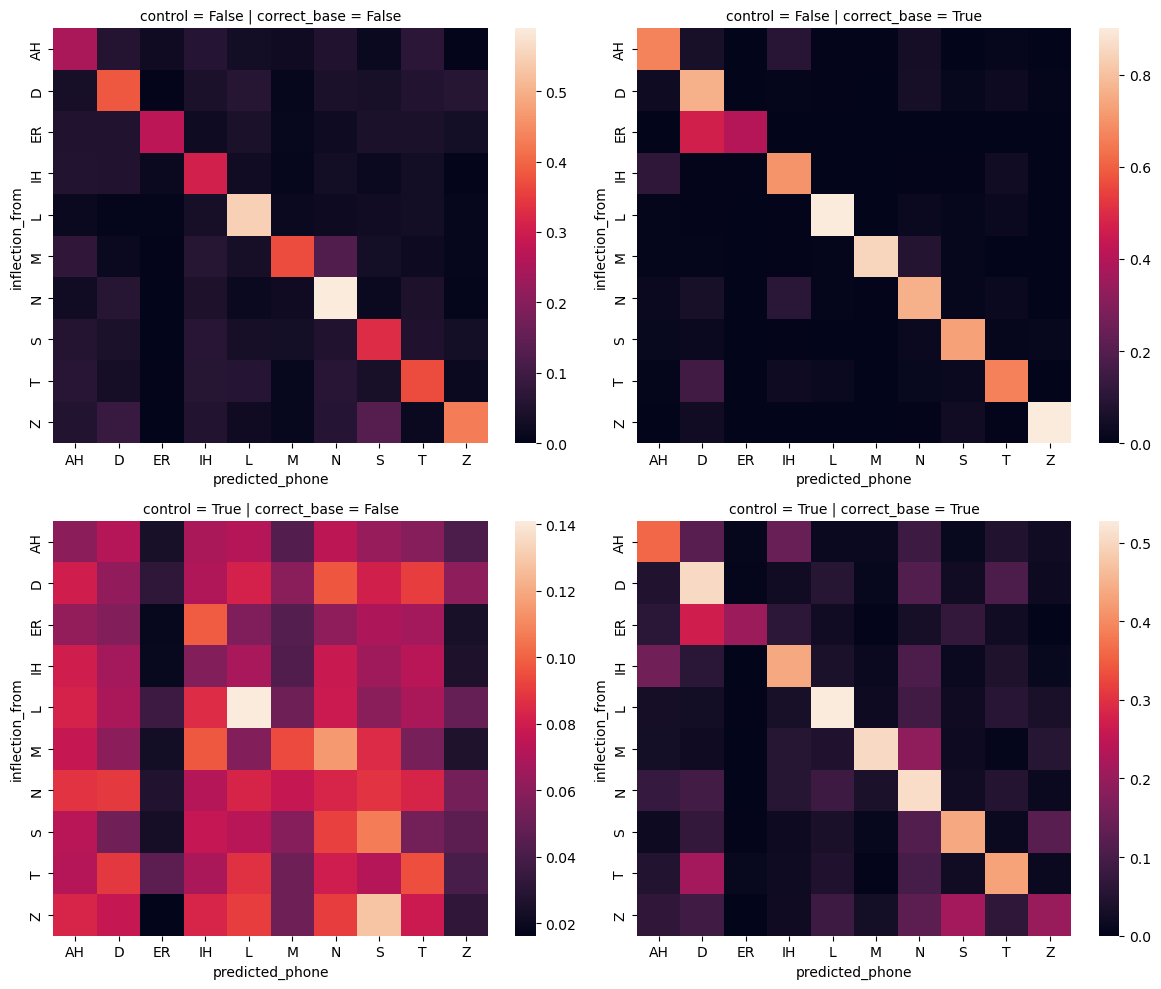

In [18]:
heatmap_results = main_results.groupby(["control", "matches_cohort_correct", "inflection_from"]) \
    .predicted_phone.value_counts(normalize=True) \
    .reindex(pd.MultiIndex.from_product(
        [[False, True], [False, True], sorted(all_phones), sorted(all_phones)],
        names=["control", "correct_base", "inflection_from", "predicted_phone"])) \
    .fillna(0)

plot_all_phones = False
g = sns.FacetGrid(data=heatmap_results.reset_index(), row="control", col="correct_base", height=5, aspect=2 if plot_all_phones else 1.2, sharex=False, sharey=False)
def f(data, **kwargs):
    sns.heatmap(data.pivot_table(index="inflection_from", columns="predicted_phone", values="proportion").reindex(sorted(all_phones), axis=1))
g.map_dataframe(f, annot=True, cmap="Blues")

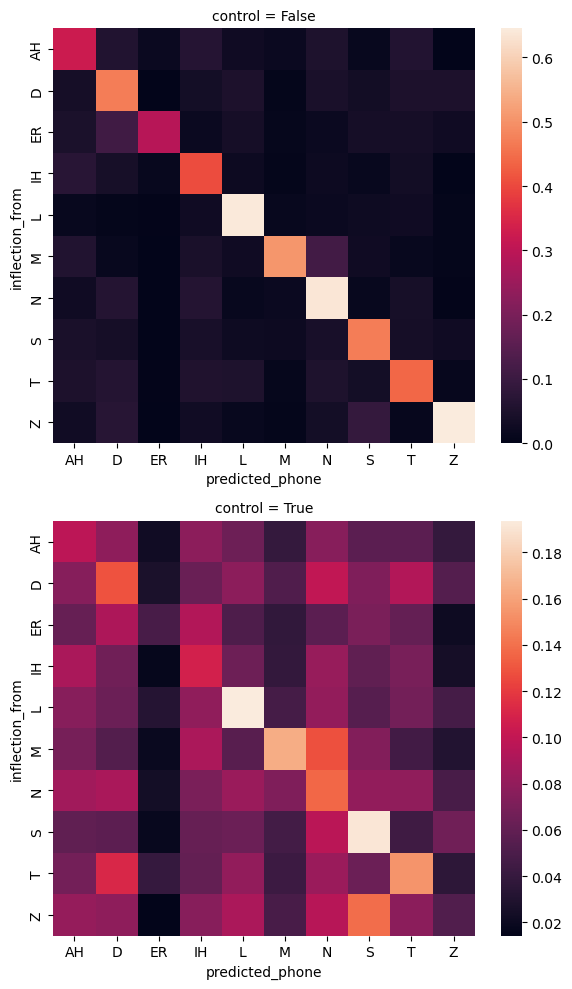

In [20]:
heatmap_results = main_results.groupby(["control", "inflection_from"]) \
    .predicted_phone.value_counts(normalize=True) \
    .reindex(pd.MultiIndex.from_product(
        [[False, True], sorted(all_phones), sorted(all_phones)],
        names=["control", "inflection_from", "predicted_phone"])) \
    .fillna(0)

plot_all_phones = False
g = sns.FacetGrid(data=heatmap_results.reset_index(), row="control", height=5, aspect=2 if plot_all_phones else 1.2, sharex=False, sharey=False)
def f(data, **kwargs):
    sns.heatmap(data.pivot_table(index="inflection_from", columns="predicted_phone", values="proportion").reindex(sorted(all_phones), axis=1))
g.map_dataframe(f, annot=True, cmap="Blues")

In [22]:
df.groupby(["control", "is_small_experiment", "to_base_phones"]).matches_next_phoneme_target_distance.mean().loc[False].sort_values()

is_small_experiment  to_base_phones
True                 ER EY             0.066777
                     K OY              0.071578
False                P EY              0.075632
                     K ER              0.082505
True                 TH AH             0.083274
False                L AY              0.084632
                     K OW              0.087918
                     R OW              0.087995
True                 F UW              0.097842
                     ER OW             0.098137
False                P ER              0.101845
True                 ER JH             0.123346
                     W AW              0.126292
                     AO G              0.130034
                     AY OW             0.132105
False                AH N              0.133169
True                 AA F              0.139032
                     EH TH             0.154143
                     Z AY              0.157864
Name: matches_next_phoneme_target_distance, dtype: f

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


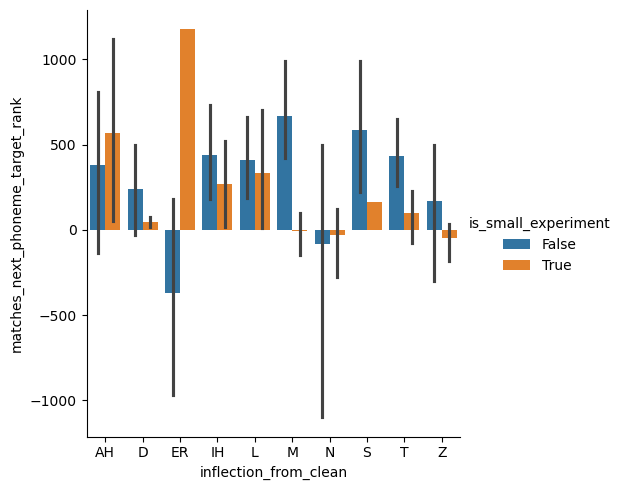

In [137]:
advantage_df = df.groupby(["control", "is_small_experiment", "inflection_from_clean", "to_base_phones"]).matches_next_phoneme_target_rank.mean()
advantage_df = advantage_df.loc[True] - advantage_df.loc[False]
advantage_df = advantage_df.dropna().reset_index()
sns.catplot(data=advantage_df, x="inflection_from_clean", y="matches_next_phoneme_target_rank", hue="is_small_experiment", kind="bar")

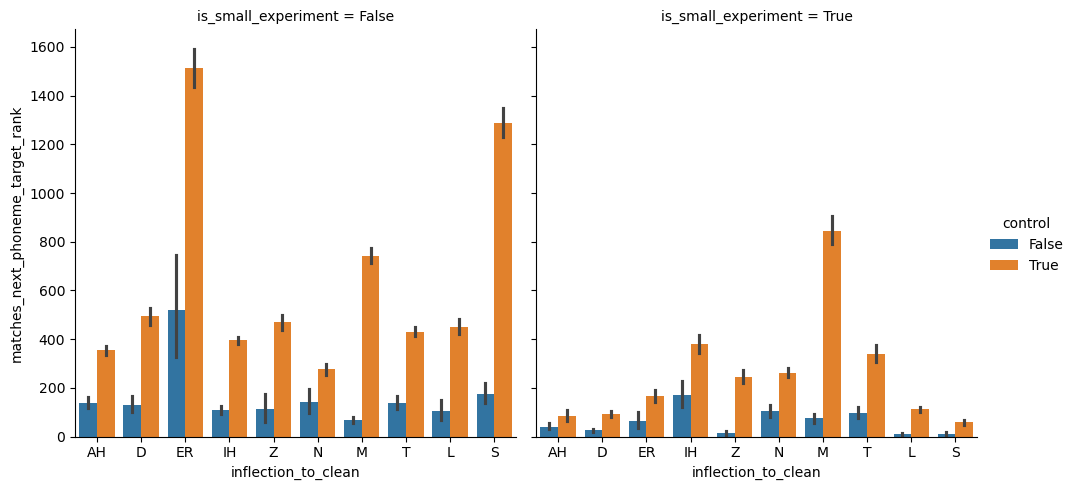

In [23]:
sns.catplot(data=df,
            x="inflection_to_clean",
            y="matches_next_phoneme_target_rank",
            hue="control", col="is_small_experiment",
            kind="bar")

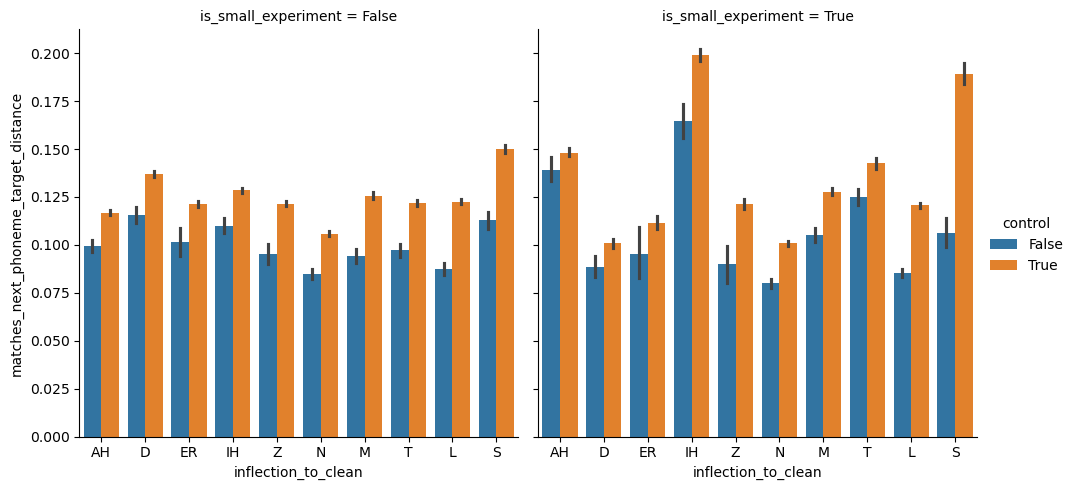

In [24]:
sns.catplot(data=df,
            x="inflection_to_clean",
            y="matches_next_phoneme_target_distance",
            hue="control", col="is_small_experiment",
            kind="bar")

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


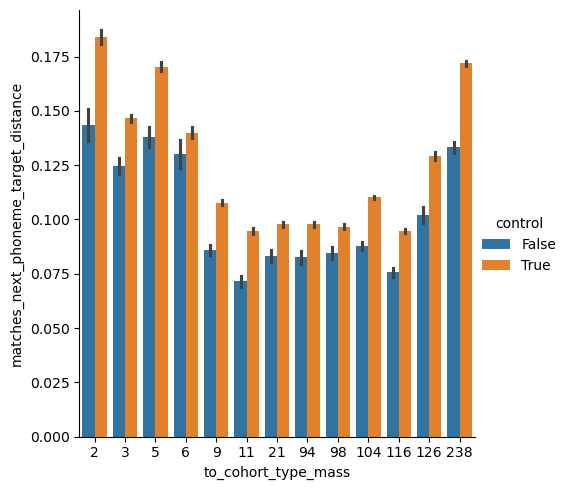

In [29]:
sns.catplot(data=df,
              x="to_cohort_type_mass", y="matches_next_phoneme_target_distance", hue="control", kind="bar")

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


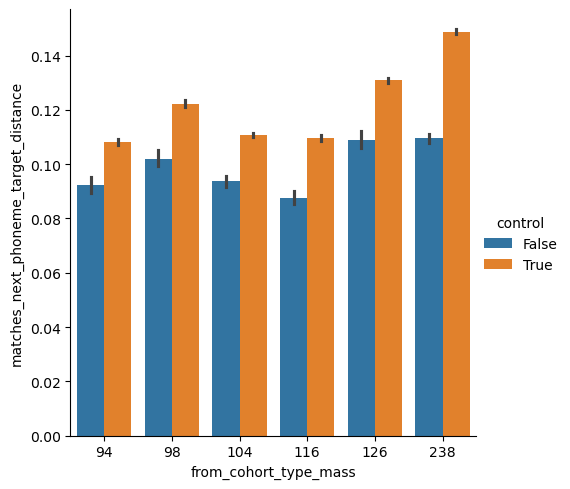

In [30]:
sns.catplot(data=df,
              x="from_cohort_type_mass", y="matches_next_phoneme_target_distance", hue="control", kind="bar")

In [31]:
df.query("not control").groupby("to").matches_next_phoneme_target_rank.agg(["mean", "std", "count"]).query("count > 15").sort_values("std").head(20)

,mean,std,count
to,,,
colon,0.588235,0.870260,17
rosary,0.736842,0.991189,19
fool,0.535714,1.061119,56
fooling,1.017857,1.070107,56
rosebud,0.789474,1.474937,19
arrangement,0.818182,1.685500,33
payne,1.863636,1.698612,22
unmitigated,1.913043,1.755848,23
rosebuds,0.947368,1.778691,19


In [32]:
df.query("not control").groupby("to").matches_next_phoneme_target_rank.agg(["mean", "std", "count"]).query("count > 15").sort_values("std").tail(20)

,mean,std,count
to,,,
coexistence,432.115385,453.456532,26
augmenting,264.120690,455.585379,58
lilacs,336.187500,472.991645,16
permeated,280.052632,490.496967,19
rowing,298.666667,503.149271,24
unnoticed,291.000000,550.071107,19
coalitions,415.476190,574.741561,21
untrained,402.388889,578.588357,18
unsettled,318.823529,592.984531,17


In [38]:
pd.merge(df.query("not control and inflection_from == 'D'").groupby("from").matches_next_phoneme_target_rank.agg(["median", "mean", "std", "count"]).query("count > 15").sort_values("median"),
         word_freq_df.LogFreq, left_index=True, right_index=True).head(10)

,median,mean,std,count,LogFreq
perdition,2.0,21.967742,64.625322,31,0.670286
production,2.0,3.576923,4.051401,26,3.394372
undergo,3.0,43.000000,105.007584,28,2.231033
rhododendron,3.0,36.592593,97.084127,27,1.048346
undoubtedly,3.5,48.187500,171.374978,32,2.300736
lied,5.5,68.035714,140.179114,28,2.552530
productive,6.0,30.653846,50.154914,26,2.991812
undergoing,6.0,104.258065,357.983330,31,2.159069
paid,7.0,27.225806,58.321357,31,3.590611
underlying,9.0,55.866667,166.732851,30,2.380022


In [39]:
pd.merge(df.query("not control and inflection_from == 'D'").groupby("from").matches_next_phoneme_target_rank.agg(["median", "mean", "std", "count"]).query("count > 15").sort_values("median"),
         word_freq_df.LogFreq, left_index=True, right_index=True).tail(10)

,median,mean,std,count,LogFreq
and,20.0,539.200000,1451.592488,25,5.896227
roadway,21.0,40.653846,78.827885,26,2.022977
road,23.5,111.375000,230.843859,32,3.866196
codicil,24.0,123.035714,399.867893,28,-0.216106
kodak,25.0,163.678571,408.801052,28,2.071057
roads,27.0,282.375000,983.188549,24,2.961720
curdling,28.0,239.000000,759.201250,27,0.814884
roadster,40.0,126.958333,294.113920,24,1.142710
rode,44.0,233.357143,724.433838,28,2.523003
roadside,47.0,94.037037,159.131412,27,2.112701


In [41]:
pd.merge(df.query("not control and inflection_to == 'D'").groupby("from").matches_next_phoneme_target_distance.agg(["median", "mean", "std", "count"]).query("count > 15").sort_values("median"),
         word_freq_df.LogFreq, left_index=True, right_index=True).head(10)

,median,mean,std,count,LogFreq
undergo,0.067653,0.092690,0.058671,22,2.231033
rhode,0.069447,0.089794,0.059496,27,2.143866
codicil,0.072398,0.090865,0.064995,22,-0.216106
kurdish,0.073149,0.098365,0.060220,20,1.409849
underlying,0.074130,0.099968,0.064991,24,2.380022
curdling,0.074482,0.093291,0.063115,21,0.814884
pedro,0.078628,0.110068,0.070269,25,2.177209
understands,0.079775,0.106801,0.065756,28,2.662461
cordite,0.080554,0.109880,0.069443,26,0.261015
cody,0.081670,0.106481,0.066421,23,2.685254


In [42]:
pd.merge(df.query("not control and inflection_to == 'D'").groupby("from").matches_next_phoneme_target_distance.agg(["median", "mean", "std", "count"]).query("count > 15").sort_values("median"),
         word_freq_df.LogFreq, left_index=True, right_index=True).tail(10)

,median,mean,std,count,LogFreq
rode,0.106850,0.123691,0.057878,22,2.523003
undergoing,0.108141,0.119946,0.068893,25,2.159069
payed,0.108458,0.119456,0.048925,18,1.457476
understood,0.109310,0.127665,0.062421,22,2.906573
undoubtedly,0.129867,0.138908,0.060257,26,2.300736
productive,0.132001,0.137093,0.043838,20,2.991812
perdition,0.134793,0.133282,0.042532,25,0.670286
roadway,0.135202,0.138755,0.076270,20,2.022977
road,0.144739,0.144882,0.069212,26,3.866196
and,0.157001,0.183351,0.090559,19,5.896227


<Axes: xlabel='std', ylabel='type_mass'>

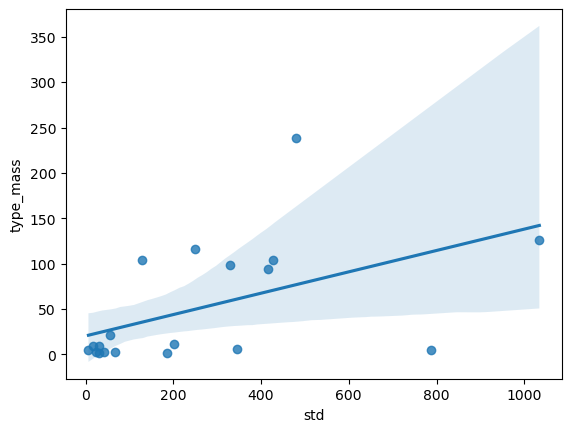

In [224]:
sns.regplot(data=pd.merge(df.query("not control").groupby("to_base_phones").matches_next_phoneme_target_rank.agg(["mean", "std"]).sort_values("std"),
         cohort_type_mass.rename("type_mass"), left_index=True, right_index=True),
         x="std", y="type_mass")

In [218]:
cohort_type_mass.sort_values()

base_phones
AY OW      2
Z AY       2
ER OW      3
AA F       3
W AW       3
EH TH      5
ER JH      5
AO G       6
ER EY      9
F UW       9
K OY      11
TH AH     21
K ER      94
L AY      98
R OW     104
K OW     104
P EY     116
P ER     126
AH N     238
Name: word, dtype: int64